# Evaluation of Runtime-Level Provenance Tracking in Python

This notebook presents a quantitative and qualitative evaluation of a modified
CPython runtime that performs automatic provenance tracking of sensitive data.

We evaluate:
- Performance overhead (latency, throughput, error rate)
- Provenance coverage across sink types
- False positive behavior on clean executions
- Practical usability through realistic application workloads


## Experimental Setup

**System variants**
- **Baseline**: Unmodified CPython 3.11
- **Instrumented**: CPython with provenance tracking enabled

**Application**
- Flask-based budget tracker with authentication, storage, and third-party sharing

**Workload**
- HTTP GET requests to `/dashboard`
- Synthetic provenance regression tests exercising multiple sink types

**Environment**
- Same hardware, same OS, same dependencies
- Only difference is the Python runtime


In [1]:
from pathlib import Path
import os, sys, json, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from subprocess import run

# --------- Paths ---------
REPO_ROOT = Path("/Users/enasbatarfi/sst-detection-system").resolve()

INSTR_PY = REPO_ROOT / "venv" / "bin" / "python"
BASELINE_PY = REPO_ROOT / "venv_baseline" / "bin" / "python"

EVAL_DIR = REPO_ROOT / "evaluation" / "eval_output"
EVAL_DIR.mkdir(parents=True, exist_ok=True)

PROV_TEST_LOG  = EVAL_DIR / "prov_provenance_test.log"
PROV_CLEAN_LOG = EVAL_DIR / "prov_clean.log"
PROV_USAGE_LOG = EVAL_DIR / "prov_usage.log"

print("Repo root:", REPO_ROOT)
print("Instrumented python:", INSTR_PY, "exists:", INSTR_PY.exists())
print("Baseline python    :", BASELINE_PY, "exists:", BASELINE_PY.exists())
print("Eval output dir    :", EVAL_DIR)

assert INSTR_PY.exists(), "Instrumented python not found"
assert BASELINE_PY.exists(), "Baseline python not found"


Repo root: /Users/enasbatarfi/sst-detection-system
Instrumented python: /Users/enasbatarfi/sst-detection-system/venv/bin/python exists: True
Baseline python    : /Users/enasbatarfi/sst-detection-system/venv_baseline/bin/python exists: True
Eval output dir    : /Users/enasbatarfi/sst-detection-system/evaluation/eval_output


In [2]:
sys.path.append(str(REPO_ROOT))
from perf_client import run_benchmark  # keep your file name

print("Imported run_benchmark from perf_client")

Imported run_benchmark from perf_client


In [3]:
results = {}

common_kwargs = dict(
    num_requests=200,
    warmup=20,
    timeout=3.0,   
)

results["baseline_dashboard"] = run_benchmark(
    url="http://127.0.0.1:5001/dashboard",
    **common_kwargs,
)

results["instrumented_dashboard"] = run_benchmark(
    url="http://127.0.0.1:5000/dashboard",
    **common_kwargs,
)

results.keys()


dict_keys(['baseline_dashboard', 'instrumented_dashboard'])

## Performance Metrics

We report the following metrics:

- **Latency (ms)**: request-response time
  - Mean, p50, p90, p95, p99
- **Throughput (req/s)**: successful requests per second
- **Error rate (%)**: failed HTTP requests
- **Effect size**: Cohen’s d between baseline and instrumented latency
- **Confidence intervals**: bootstrap 95% CIs


In [4]:
def pct_over(new, base):
    return ((new - base) / base * 100.0) if base else float('nan')

base = results["baseline_dashboard"]
instr = results["instrumented_dashboard"]

rows = []
for label, res in [("baseline", base), ("instrumented", instr)]:
    rows.append({
        "setup": label,
        "n_ok": res.get("n", len(res.get("latencies", []))),
        "throughput_rps": res["throughput"],
        "error_rate_pct": res["error_rate"] * 100,
        "mean_ms": res["mean"],
        "p50_ms": res["p50"],
        "p90_ms": res["p90"],
        "p95_ms": res["p95"],
        "p99_ms": res["p99"],
    })

summary_df = pd.DataFrame(rows)

overheads = pd.DataFrame([{
    "mean_overhead_pct": pct_over(instr["mean"], base["mean"]),
    "p95_overhead_pct":  pct_over(instr["p95"],  base["p95"]),
    "p99_overhead_pct":  pct_over(instr["p99"],  base["p99"]),
    "throughput_drop_pct": ((base["throughput"] - instr["throughput"]) / base["throughput"] * 100.0) if base["throughput"] else float('nan'),
    "error_rate_delta_pct": (instr["error_rate"] - base["error_rate"]) * 100,
}])

display(summary_df)
display(overheads)


,setup,n_ok,throughput_rps,error_rate_pct,mean_ms,p50_ms,p90_ms,p95_ms,p99_ms
0,baseline,200,835.174922,0.0,1.197170,1.178041,1.270709,1.312583,1.404458
1,instrumented,200,26.592038,0.0,37.604923,36.674792,39.627084,42.749000,57.919208


,mean_overhead_pct,p95_overhead_pct,p99_overhead_pct,throughput_drop_pct,error_rate_delta_pct
0,3041.152725,3156.860707,4023.95443,96.815992,0.0


In [5]:
def bootstrap_ci(data, stat_fn, n_boot=2000, alpha=0.05, seed=0):
    rng = np.random.default_rng(seed)
    data = np.asarray(data)
    if len(data) == 0:
        return (np.nan, np.nan, np.nan)
    stats = []
    for _ in range(n_boot):
        sample = rng.choice(data, size=len(data), replace=True)
        stats.append(stat_fn(sample))
    stats = np.sort(stats)
    lo = stats[int((alpha/2) * n_boot)]
    hi = stats[int((1 - alpha/2) * n_boot) - 1]
    return (float(np.mean(stats)), float(lo), float(hi))

def cohen_d(a, b):
    a = np.asarray(a); b = np.asarray(b)
    if len(a) < 2 or len(b) < 2:
        return np.nan
    va = a.var(ddof=1); vb = b.var(ddof=1)
    pooled = math.sqrt(((len(a)-1)*va + (len(b)-1)*vb) / (len(a)+len(b)-2))
    return (a.mean() - b.mean()) / pooled if pooled > 0 else np.nan

base_lat = np.array(base["latencies"])
instr_lat = np.array(instr["latencies"])

mean_base_ci = bootstrap_ci(base_lat, np.mean)
mean_instr_ci = bootstrap_ci(instr_lat, np.mean)

p95_base_ci = bootstrap_ci(base_lat, lambda x: np.percentile(x, 95))
p95_instr_ci = bootstrap_ci(instr_lat, lambda x: np.percentile(x, 95))

d = cohen_d(instr_lat, base_lat)

stats_df = pd.DataFrame([
    {"metric":"mean_ms", "baseline_est": mean_base_ci[0], "baseline_ci":[mean_base_ci[1], mean_base_ci[2]],
     "instr_est": mean_instr_ci[0], "instr_ci":[mean_instr_ci[1], mean_instr_ci[2]]},
    {"metric":"p95_ms", "baseline_est": p95_base_ci[0], "baseline_ci":[p95_base_ci[1], p95_base_ci[2]],
     "instr_est": p95_instr_ci[0], "instr_ci":[p95_instr_ci[1], p95_instr_ci[2]]},
])

display(stats_df)
print("Cohen's d (instrumented vs baseline):", d)


,metric,baseline_est,baseline_ci,instr_est,instr_ci
0,mean_ms,1.197121,"[1.1895734649078804, 1.2046474298040266]",37.600099,"[36.97807495478628, 38.29721954982233]"
1,p95_ms,1.309359,"[1.277916002436541, 1.342332994681783]",44.666070,"[40.07087500212947, 55.9007747000578]"


Cohen's d (instrumented vs baseline): 10.70521322901285


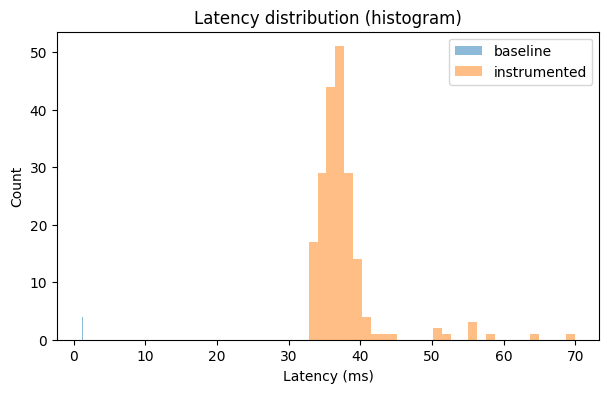

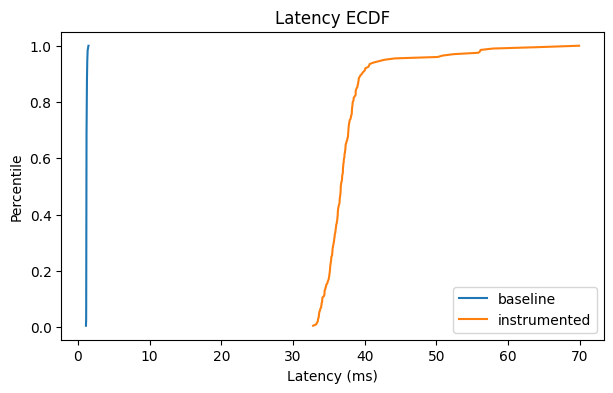

<Figure size 600x400 with 0 Axes>

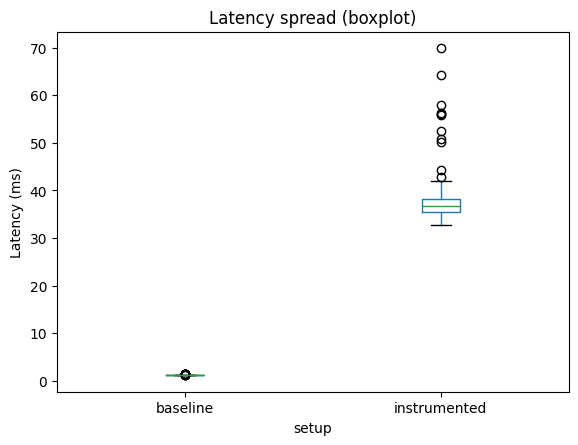

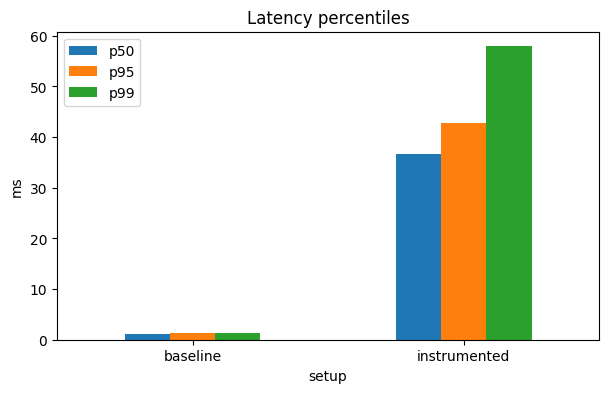

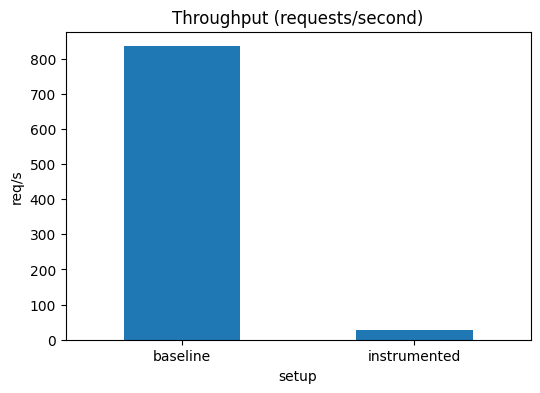

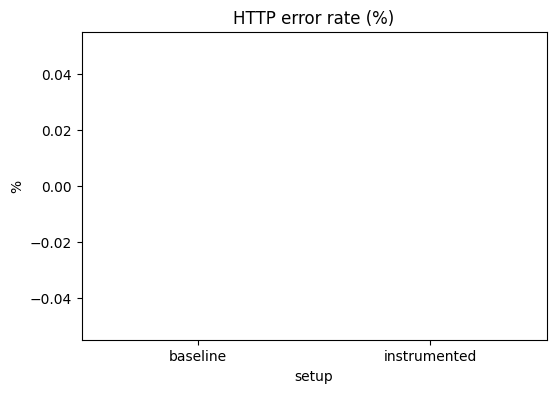

In [6]:
# Prepare DF for plotting
lat_df = pd.DataFrame({
    "baseline": base_lat,
    "instrumented": instr_lat
}).melt(var_name="setup", value_name="latency_ms")

# 1) Histogram
plt.figure(figsize=(7,4))
for name, sub in lat_df.groupby("setup"):
    plt.hist(sub["latency_ms"], bins=30, alpha=0.5, label=name)
plt.title("Latency distribution (histogram)")
plt.xlabel("Latency (ms)")
plt.ylabel("Count")
plt.legend()
plt.show()

# 2) ECDF
plt.figure(figsize=(7,4))
for name, sub in lat_df.groupby("setup"):
    x = np.sort(sub["latency_ms"].values)
    y = np.arange(1, len(x)+1) / len(x)
    plt.plot(x, y, label=name)
plt.title("Latency ECDF")
plt.xlabel("Latency (ms)")
plt.ylabel("Percentile")
plt.legend()
plt.show()

# 3) Boxplot
plt.figure(figsize=(6,4))
lat_df.boxplot(column="latency_ms", by="setup", grid=False)
plt.title("Latency spread (boxplot)")
plt.suptitle("")
plt.ylabel("Latency (ms)")
plt.show()

# 4) Percentiles bar plot
pct_table = pd.DataFrame([
    {"setup":"baseline",      "p50": base["p50"],  "p95": base["p95"],  "p99": base["p99"]},
    {"setup":"instrumented",  "p50": instr["p50"], "p95": instr["p95"], "p99": instr["p99"]},
]).set_index("setup")

pct_table.plot(kind="bar", figsize=(7,4))
plt.title("Latency percentiles")
plt.ylabel("ms")
plt.xticks(rotation=0)
plt.show()

# 5) Throughput bar plot
thr_df = pd.DataFrame([
    {"setup":"baseline", "throughput_rps": base["throughput"]},
    {"setup":"instrumented", "throughput_rps": instr["throughput"]},
]).set_index("setup")

thr_df.plot(kind="bar", figsize=(6,4), legend=False)
plt.title("Throughput (requests/second)")
plt.ylabel("req/s")
plt.xticks(rotation=0)
plt.show()

# 6) Error rate bar plot
err_df = pd.DataFrame([
    {"setup":"baseline", "error_rate_pct": base["error_rate"]*100},
    {"setup":"instrumented", "error_rate_pct": instr["error_rate"]*100},
]).set_index("setup")

err_df.plot(kind="bar", figsize=(6,4), legend=False)
plt.title("HTTP error rate (%)")
plt.ylabel("%")
plt.xticks(rotation=0)
plt.show()


## Provenance Coverage Evaluation

We execute a comprehensive provenance regression that exercises:

- stdout / stderr / logging
- File writes (text, JSON, Path.write_text)
- Network sends (raw sockets, HTTP, HTTPS)
- Simulated third-party data sharing

We analyze the resulting provenance log to measure:
- Sink coverage
- Owner propagation
- Destination diversity


In [7]:
# Clean old log
if PROV_TEST_LOG.exists():
    PROV_TEST_LOG.unlink()

env = os.environ.copy()
env["PY_PROVENANCE_LOG_JSON"] = str(PROV_TEST_LOG)
env["PY_PROVENANCE_SOURCE"] = "provenance_test"

print("Running test_cases/test_provenance.py under instrumented python…")
proc = run([str(INSTR_PY), "test_cases/test_provenance.py"], cwd=str(REPO_ROOT), env=env)
print("Exit code:", proc.returncode)

assert PROV_TEST_LOG.exists(), "prov_provenance_test.log not created"

size_kb = PROV_TEST_LOG.stat().st_size / 1024
print("Provenance log size (KB):", round(size_kb, 2))

# Parse JSONL robustly (your file can contain multiple JSON objects without newlines sometimes)
from collections import Counter

sink_counts = Counter()
owner_counts = Counter()
dest_counts = Counter()

text = PROV_TEST_LOG.read_text()
dec = json.JSONDecoder()
i = 0
n = len(text)

objs = 0
while i < n:
    try:
        obj, end = dec.raw_decode(text, i)
    except json.JSONDecodeError:
        i += 1
        continue
    i = end
    if isinstance(obj, dict) and "sink" in obj:
        objs += 1
        sink = obj.get("sink", "unknown")
        sink_counts[sink] += 1
        dest_counts[obj.get("dest", "unknown")] += 1
        for o in obj.get("owners", []):
            owner_counts[o] += 1

print("Total events parsed:", objs)
display(pd.DataFrame(sink_counts.items(), columns=["sink","count"]).sort_values("count", ascending=False))
display(pd.DataFrame(owner_counts.items(), columns=["owner","event_count"]).sort_values("event_count", ascending=False).head(10))


Running test_cases/test_provenance.py under instrumented python…
=== Provenance test: propagation and sink coverage ===
Using log: /Users/enasbatarfi/sst-detection-system/evaluation/eval_output/prov_provenance_test.log
Output dir: /Users/enasbatarfi/sst-detection-system/test_cases/output_files
Alice email: alice@example.com
Alice age: 30
Alice nationality: USA
Helper email: alice@example.com  --- 
Alice email modified: alice@example.com -- verified
Clean number (should stay clean): 70
Alice age modified: 999
Alice and Bob ages combined: 1024
Bob age: 25
Bob nationality: Canada - North America
Income difference: -0.5
Bob income plus 1000: 1600.0
Bob income plus 0.5: 600.5
Bob age modified: 30
Combined modified ages: 1029
stdout test: 999


stderr test: 999


=== Done ===
Exit code: 0
Provenance log size (KB): 8.11
Total events parsed: 36


,sink,count
0,stdout,17
3,socket_send,9
1,file_write,8
2,stderr,2


,owner,event_count
0,alice@example.com,31
1,bob@example.com,8


In [8]:
# Presence checks (defensible without modifying test code)
checks = [
    ("has_stdout", sink_counts.get("stdout", 0) > 0, "At least one stdout event"),
    ("has_stderr", sink_counts.get("stderr", 0) > 0, "At least one stderr/logging event"),
    ("has_file_write", sink_counts.get("file_write", 0) > 0, "At least one file_write event"),
    ("has_socket_send", sink_counts.get("socket_send", 0) > 0, "At least one socket_send event"),
]

# Destination checks (specific files your test writes)
expected_dests = [
    "test_cases/output_files/test_text.txt",
    "test_cases/output_files/test_json.json",
    "test_cases/output_files/test_json2.json",
    "test_cases/output_files/test_json3.json",
    "test_cases/output_files/test_path.txt",
    "budget_tracker/shared_with_third_parties/third_party_marketing.txt",
]
dest_ok = []
dest_keys = list(dest_counts.keys())
for d in expected_dests:
    ok = any(d in (k or "") for k in dest_keys)
    dest_ok.append((f"dest_contains:{d}", ok, f"Found dest containing {d}"))

checks_df = pd.DataFrame(checks + dest_ok, columns=["check","pass","notes"])
display(checks_df)

# Coverage score: percent of checks passing
coverage_pct = checks_df["pass"].mean() * 100
print("Coverage score (% checks passed):", round(coverage_pct, 1))


,check,pass,notes
0,has_stdout,True,At least one stdout event
1,has_stderr,True,At least one stderr/logging event
2,has_file_write,True,At least one file_write event
3,has_socket_send,True,At least one socket_send event
4,dest_contains:test_cases/output_files/test_tex...,True,Found dest containing test_cases/output_files/...
5,dest_contains:test_cases/output_files/test_jso...,True,Found dest containing test_cases/output_files/...
6,dest_contains:test_cases/output_files/test_jso...,True,Found dest containing test_cases/output_files/...
7,dest_contains:test_cases/output_files/test_jso...,True,Found dest containing test_cases/output_files/...
8,dest_contains:test_cases/output_files/test_pat...,True,Found dest containing test_cases/output_files/...
9,dest_contains:budget_tracker/shared_with_third...,True,Found dest containing budget_tracker/shared_wi...


Coverage score (% checks passed): 100.0


## False Positive Analysis

To estimate false positives, we execute a clean program that performs
no sensitive data operations.

Any provenance event produced in this run is considered a false positive.


In [10]:
# Run clean-only test to estimate false positives
if PROV_CLEAN_LOG.exists():
    PROV_CLEAN_LOG.unlink()

env = os.environ.copy()
env["PY_PROVENANCE_LOG_JSON"] = str(PROV_CLEAN_LOG)
env["PY_PROVENANCE_SOURCE"] = "clean_test"

# IMPORTANT: this file must exist
clean_script = REPO_ROOT / "test_cases" / "test_clean.py"
assert clean_script.exists(), "Create test_cases/test_clean.py first"

proc = run([str(INSTR_PY), str(clean_script)], cwd=str(REPO_ROOT), env=env)
print("Exit code:", proc.returncode)

false_pos = 0
if PROV_CLEAN_LOG.exists():
    text = PROV_CLEAN_LOG.read_text()
    dec = json.JSONDecoder()
    i = 0
    while i < len(text):
        try:
            obj, end = dec.raw_decode(text, i)
        except json.JSONDecodeError:
            i += 1
            continue
        i = end
        if isinstance(obj, dict) and "sink" in obj:
            false_pos += 1

print("False positives (events in clean-only run):", false_pos)

fp_df = pd.DataFrame([{"false_positive_events": false_pos}])
display(fp_df)


This is a clean print, no emails, no user ids.
Exit code: 0
False positives (events in clean-only run): 0


,false_positive_events
0,0


,log,kb
0,provenance_test,8.108398
1,clean_only,0.000000
2,usage,6.486328


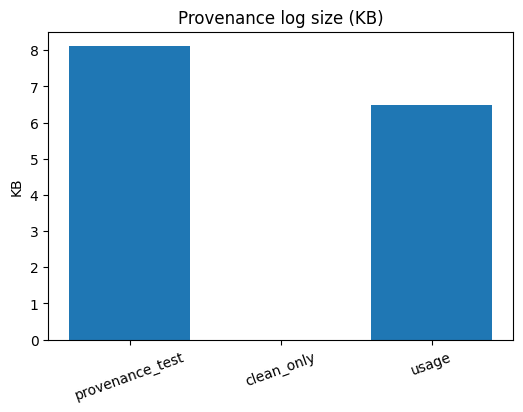

In [13]:
sizes_kb = {
    "provenance_test": PROV_TEST_LOG.stat().st_size / 1024 if PROV_TEST_LOG.exists() else 0,
    "clean_only": PROV_CLEAN_LOG.stat().st_size / 1024 if PROV_CLEAN_LOG.exists() else 0,
    "usage": PROV_USAGE_LOG.stat().st_size / 1024 if PROV_USAGE_LOG.exists() else 0,
}

size_df = pd.DataFrame([sizes_kb]).T.reset_index()
size_df.columns = ["log", "kb"]
display(size_df)

plt.figure(figsize=(6,4))
plt.bar(size_df["log"], size_df["kb"])
plt.title("Provenance log size (KB)")
plt.ylabel("KB")
plt.xticks(rotation=20)
plt.show()
